# Problem 2: Markovian Transition Matrix of Complex Environment

We model the complex environment by introducing chaotic flow. We want then to discretize this environment into cells and extract the transition probability from switching between those cells. 


## Chaotic Flow 

We consider the flow in a sphere without rotational flow in the co-moving frame (see mixingLetter):

$$
 \vec v_t\left(r\right) = \left(1-2r^2\right) \hat n + \left(\hat n \cdot \vec r \right) \vec r.
$$

The orientation of the swimmer $\hat n$ in spherical coordinates:
$$ 
\hat n \left(t\right)= \begin{pmatrix}
           \sin \theta\left(t\right) \cos \phi\left(t\right) \\
           \sin \theta\left(t\right) \sin \phi\left(t\right) \\
           \cos \theta\left(t\right)
         \end{pmatrix}
$$

By choosing $\phi\left(t\right) = 0$, we now only consider 2D flow in x-z plane. In addition, we introduce a harmonic time dependence 
$
\theta\left(t\right) = \Delta \theta \cos\left(t\right).
$
Chaotic behavior can be observed when choosing $\Delta \theta = k \pi /180$ with $k=30$.

The trajectory of one particle in that flow is given by
$$
\frac{\mathrm{d} \vec r}{ \mathrm{d} t} = a_t \vec v_t\left(\vec r\right)
$$
with $a_t =1.$

We are interested in the transition probability after $N$ periods $t_k = 2 \pi k$

Calculate the trajectory for particles that are advecting in the flow $\vec v_t$ during the time $T=n \cdot t_k$. The geometry is discretized into $N_{\mathrm{angle}}$ angular parts and into $N_{\mathrm{radial}}$ parts, as shown above.  The starting position $(r_0, \theta_0)$ is given by 
$$
\theta_0 = i \cdot \frac{2\pi}{N_{\mathrm{angle}}} + \frac{2\pi}{N_{\mathrm{angle}}} \chi
$$
where $\chi\in \left[0, 1\right]$ and $i = 0 \ldots N_{\mathrm{angle}}-1$ for each slab.

The radial component is given by
$$
r_0 = \sqrt{\xi}\\
$$ 
with $\xi \in \left[r_j^2, \left(r_{j} + \Delta r\right)^2\right]$, where $\Delta r = \frac{1}{N_{\mathrm{radial}}}$.

[//]: # (To improve statistics, the number of starting points in the cells is scaled with the area of the cell.)




## Parameters

In [1]:
### variable parameter
nPeriods=2
k=30
nParticles = 4000
nRadial = 2
nAngular = 8
nStrobo = 8  ## how often snapshot per period 

nStartCells = 16  # for test purposes, min =1, max=nRadial*nAngular

---

# Implementation 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import math
import os.path
plt.style.use(['ggplot','seaborn-poster', 'customStyle' ])


# Compute areas and colors
def plotGridSectionEmpty(nRadial=2, nAngular=8, nParticles = 2e4):
    """ plot grids in discretized space. 
    @param nRadial  number of compartments in radial direction
    @param nAngular  number of compartments in angular direction
    """
    r = np.linspace(0,1,nRadial+1)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_rticks([])
    ax.set_xticks([])
    ax.grid(False)
    
    ### plot rings
    theta = 2 * np.pi * np.linspace(0,1,360)
    for radius in r[1:]:
        ring = radius * np.ones(360)
        ax.plot(theta, ring, 'k')

    ### plot slabs
    for i in range(nAngular):
        slab = i * 2 * np.pi/nAngular * np.ones(nRadial+1)
        ax.plot(slab,r,'k')

    ### show uniform distribution
    for i in range(nRadial):
        dTheta = 2 * np.pi/nAngular
        dA = 0.5 * (r[i+1]**2 - r[i]**2) * dTheta
#         nParticles = int(nParticles * dA)
        print("ring number %d has %d particles"%(i, nParticles))
        xi = np.random.uniform(r[i]**2, r[i+1]**2, nParticles)
        chi = np.random.uniform(0,1,nParticles)
        thetaRand =  dTheta * chi 
        ax.scatter(thetaRand, np.sqrt(xi), s=1)
    plt.show()

def plotVectorField(vField, x, z,i):  
    plt.ioff()
    vx = vField[:,:,0]
    vz = vField[:,:,2]
    fig, ax = plt.subplots(1, figsize=(4,4))
    ax.streamplot(xx, zz, vx, vz, linewidth=1)
    circle = matplotlib.patches.Circle((0,0), radius=1,facecolor='none', edgecolor='black', lw=2.5)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.grid(False)
    
    plt.savefig('./plots/field%03d.png'%i, bbox_inches='tight', dpi=250)
    plt.close(fig)    

def toPolar(traj):
    """ convert 2d cartesian coordinates to polar coordinates r, theta
        @params traj  trajectory with x,y components
        @return (r, theta)  tuple of radial and angular component
    """
    x,y = traj[:,0], traj[:,2]
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(y,x)  # from -pi to pi
    return (r,theta)
def toCartesian(r, theta):
    """ convert 2d polar coordinates to cartesian coordinates x, y
        @params traj  trajectory with r, theta components
        @return (x, y)  tuple of x and y component
    """
    x = r * np.cos(theta)
    y = np.zeros(len(theta))
    z = r * np.sin(theta)
    return (x,y,z)

def plotGridSection(trajectories, period=0):
    """ plot particle positions for chosen period. Default is starting position
        @params trajectories  list of trajectories
        @params period  int which period to plot
    """
    ### def parameter for cells
    r = np.linspace(0,1,2)
    innerRing = 0.5 * np.ones(360)
    outerRing = np.ones(360)
    theta = 2 * np.pi * np.linspace(0,1,360)
    ### def slabs
    slabs=[]
    for i in range(8):
        slab =i* np.pi/4  * np.ones(2)
        slabs.append(slab)
    ### figure options
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    ax.set_rticks([])
    ax.set_xticks([])
    ax.grid(False)
    
    ### plot cell grid
    for slab in slabs:
        ax.plot(slab,r,'k')   
    ax.plot(theta, innerRing, 'k')
    ax.plot(theta, outerRing,'k')
    
    ### plot position
    r, theta = toPolar(trajectories[period]) 
    ax.scatter(theta, r, s=3, marker='.')
    plt.show()

def getListOfStartPos(nRadial=2, nAngular=8, N=2e3):
    """ create list of starting positions. Iterate over each cell, depending on radial and angular discretization
        @param nRadial
        @param nAngular
        @return startPos  list of starting positions of nParticles (x,0,z)
    """
    listOfStartPos=[]
    R = np.linspace(0,1,nRadial+1)
    dTheta = 2 * np.pi/nAngular
    for i in range(nRadial):
#         dA = 0.5 * (R[i+1]**2 - R[i]**2) * dTheta  ## scale with area?
        dA=1
        nParticles = int(N * dA)
        for j in range(nAngular):
            # generate uniformly distributed random numbers
            xi = np.random.uniform(R[i]**2, R[i+1]**2, nParticles)
            chi = np.random.uniform(0,1,nParticles)
        
            theta =  dTheta * chi + j * dTheta
            r = np.sqrt(xi)
            x,y,z = toCartesian(r, theta)
            listOfStartPos.append(np.array([x,y,z]).transpose())
    return(listOfStartPos)

def plotStrobo(cell, period):  
    """ plot stroboscopic map for cell
    """
    fig, ax = plt.subplots(1, figsize=(4,4))
    
    circle = matplotlib.patches.Circle((0,0), radius=1,facecolor='none', edgecolor='black', lw=2.5)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)
    ax.grid(False)
    ax.scatter(cell[:,period,0], cell[:,period,2],s=3, color ='r')
    ax.set_title("Stroboscopic Period %d" % period)
    plt.show()
    
def vTrans(t, r, deltaTheta):
    """ calculate translational velocity (see top)
        @params r  numpy array of length nParticles with positions
        @params t  current integration time
        @return vTrans  numpy array of length nParticles with velocities
    """ 
#     vectorized implementation
#     theta = DELTA_THETA * np.cos(t)  * np.ones(len(r))
#     nHat = np.array([np.sin(theta),np.zeros(len(r)),np.cos(theta)]).transpose()
#     rNorm = np.linalg.norm(r, axis=1, keepdims=True)
#     vTrans = (1- 2 * rNorm**2)*nHat + np.sum( (nHat * r), axis=1,keepdims=True ) * r

    theta = deltaTheta * np.cos(t)
    nHat = np.array([np.sin(theta), 0, np.cos(theta)])
    rNorm = np.linalg.norm(r)
    vTrans = (1-2*rNorm**2)*nHat + np.dot(nHat, r)*r
    return vTrans

def calcTransitionMatrix(results, nRadial, nAngular, nParticles, period):
    """ calculate the probabilities of the transition matrix for given period.
        @params results  stroboscopic positions of advecting particles
        @params nRadial
        @params nAngular
        @params nParticles
        @params period
        @return returns numpy array of shape (nRadial*nAngular, nRadial*nAngular) with probabilities
    """
    nCells = nRadial * nAngular
    transitionMatrix = np.zeros((nCells,nCells))

    dr = 1/ nRadial
    dTheta = 2 *math.pi /nAngular
    for i in range(nCells):
        density = np.zeros(nCells)
        pos = results[i,:,period]
#         print(type(pos))
        r, theta = toPolar(pos)
        for j in range(nParticles):
            if theta[j] < 0 :
                theta[j] += 2*math.pi  # cave: theta [-pi,pi], need to add 2*pi for correct cell index
            # check for particles out of bounds, maybe introduce particle count
            if r[j]<1:
                rCell = math.floor(r[j]/dr)
                thetaCell = math.floor((theta[j])/dTheta)
                cellIndx = rCell * nAngular + thetaCell
                density[cellIndx] +=1
            
        transitionMatrix[i] = density/nParticles 
        
    
    ### plot transition matrix 
    fig, ax = plt.subplots(1)
    imgplot = ax.imshow(transitionMatrix.transpose(), origin='lower')
    plt.colorbar(imgplot)
    ax.set_xlabel('coming from cell number')
    ax.set_ylabel('arriving at cell number')
    ax.set_title("Stroboscopic period %d" % period)
    plt.grid(False)
    plt.show()
    
    return transitionMatrix    

### Show choice of discretization

ring number 0 has 4000 particles
ring number 1 has 4000 particles


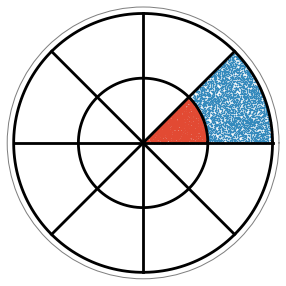

In [3]:
### plot default discretization
plotGridSectionEmpty(nRadial, nAngular, nParticles)

In [4]:
from scipy.integrate import odeint
import time 

### these parameter follow from variable parameters
deltaTheta = k * np.pi / 180
tk = 2 * math.pi * k
evalT = np.arange(nPeriods) * tk
T = tk * nPeriods
periodLength = 2000
stroboView = int(periodLength/nStrobo)
nTimesteps = periodLength * nPeriods
t0 = 0 
t = np.linspace(t0,T,nTimesteps+1)
filename =str("result_k%d_r%d_theta%d_%d.npy"%(k, nRadial,nAngular,nParticles))

# print("Simulation time is %0.2f "%T)
if not os.path.isfile(filename):
    print("No file %s found. Start calculation of trajectories!" % filename)
    
    listOfStartPos = getListOfStartPos(nRadial,nAngular,nParticles)[:nStartCells]
    resultsArray = np.full((nRadial*nAngular,nParticles,nPeriods*nStrobo+1,3),np.nan)

    for i, cell in enumerate(listOfStartPos):
        start = time.time()
        print("Iterating over %d particles for cell number %d " % (len(cell), i))
        ### TODO: get rid of this loop by vectorizing vTrans
        for j, particlePos in enumerate(cell):

            sol = odeint(vTrans, particlePos, t, args=(deltaTheta,),tfirst=True,full_output = 1 )
            ### stroboscopic output
            resultsArray[i,j] = sol[0][::stroboView]
        end = time.time()
        print("this took %0.2f s" % (end-start))
    np.save(filename,resultsArray)
else:
    resultsArray = np.load(filename)
    print("File %s already exists. Trajectories will not be recalculated. Loaded file instead!" % filename)

No file result_k30_r2_theta8_4000.npy found. Start calculation of trajectories!
Iterating over 4000 particles for cell number 0 


/share/scratch2/telezki/Programs/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


this took 492.66 s
Iterating over 4000 particles for cell number 1 
this took 490.83 s
Iterating over 4000 particles for cell number 2 
this took 493.38 s
Iterating over 4000 particles for cell number 3 
this took 496.92 s
Iterating over 4000 particles for cell number 4 
this took 494.07 s
Iterating over 4000 particles for cell number 5 
this took 497.57 s
Iterating over 4000 particles for cell number 6 
this took 500.05 s
Iterating over 4000 particles for cell number 7 
this took 499.02 s
Iterating over 4000 particles for cell number 8 
this took 495.58 s
Iterating over 4000 particles for cell number 9 
this took 496.72 s
Iterating over 4000 particles for cell number 10 
this took 493.44 s
Iterating over 4000 particles for cell number 11 
this took 504.15 s
Iterating over 4000 particles for cell number 12 
this took 501.96 s
Iterating over 4000 particles for cell number 13 
this took 501.55 s
Iterating over 4000 particles for cell number 14 
this took 497.41 s
Iterating over 4000 part

### Stroboscopic view for starting configuration in one cell:

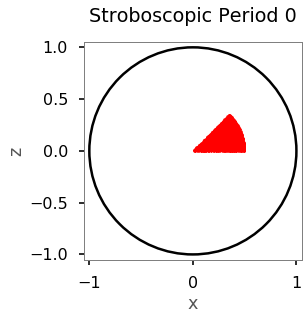

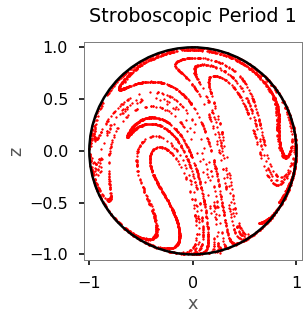

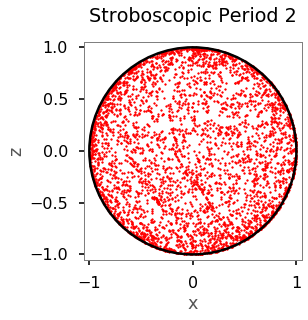

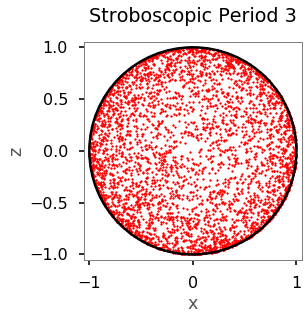

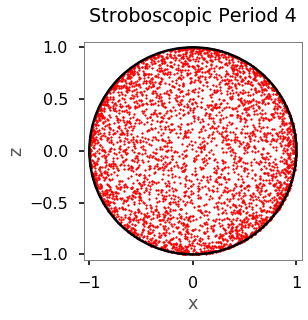

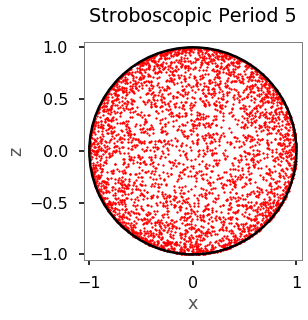

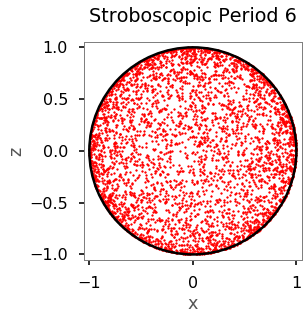

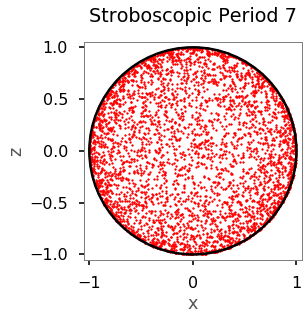

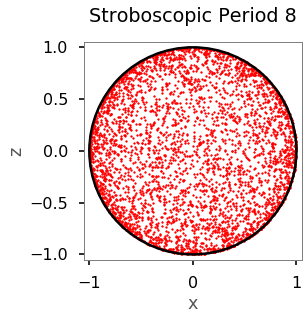

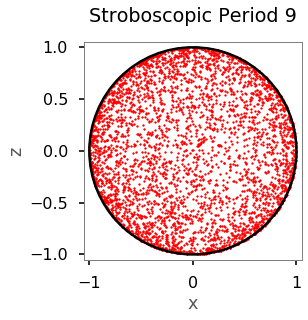

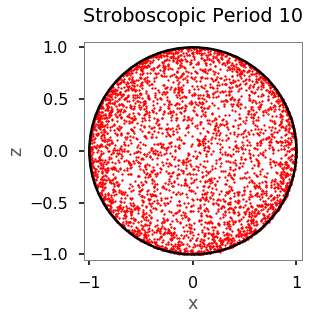

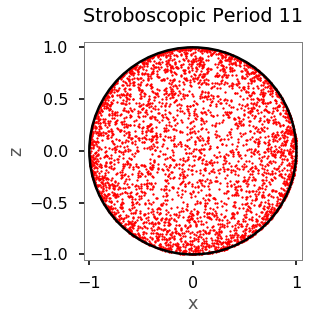

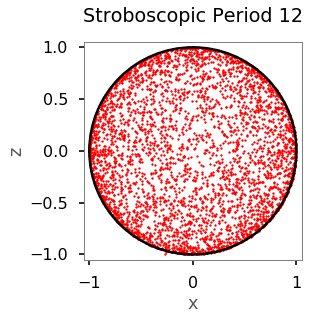

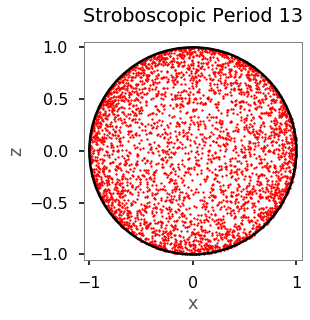

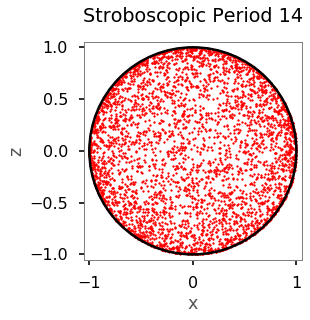

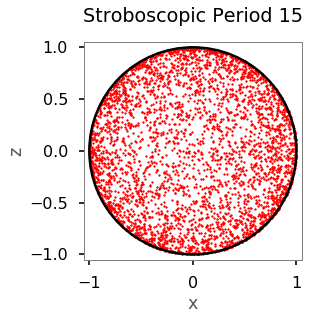

In [9]:
cell = resultsArray[0]
for period in range(nPeriods*nStrobo):
    plotStrobo(cell, period)

## Calculate Transition Matrix
Now that we have the stroboscopic positions of the advecting particles for the given discretization, we can calculate the transition matrix. 

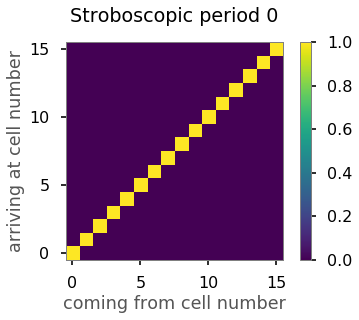

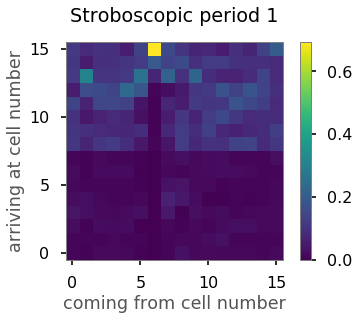

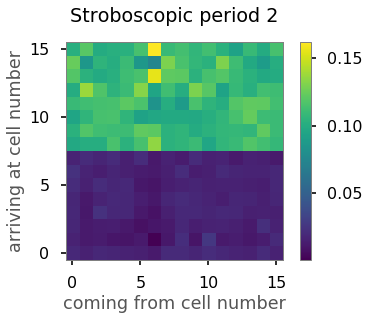

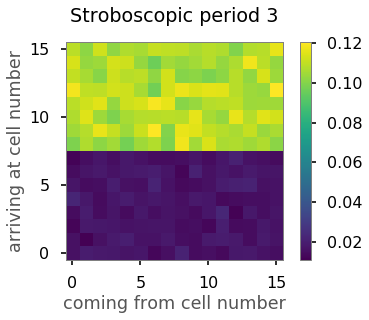

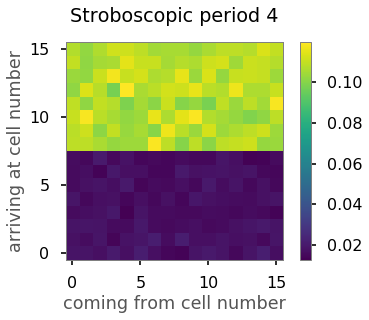

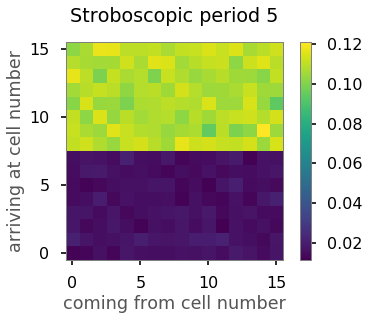

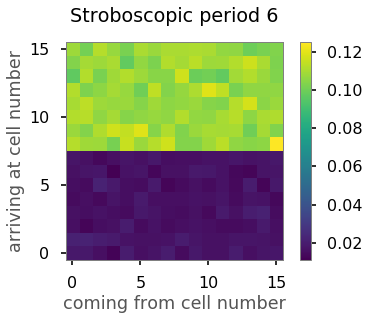

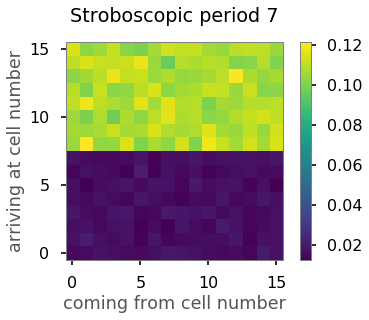

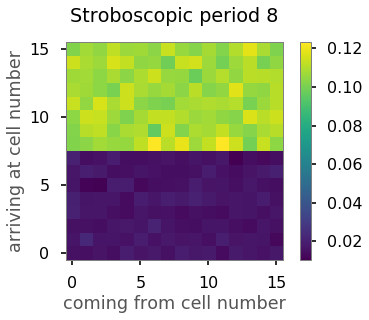

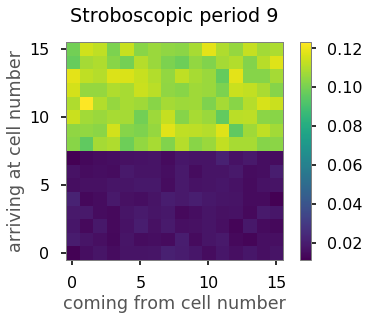

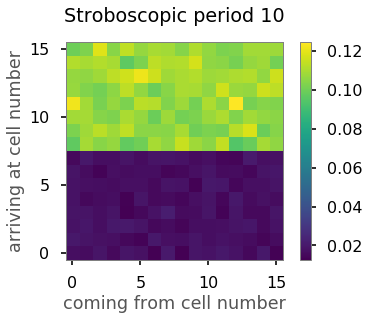

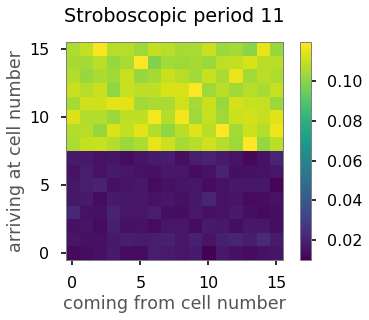

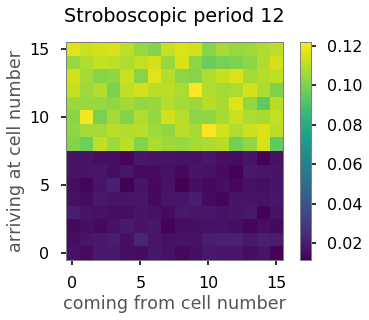

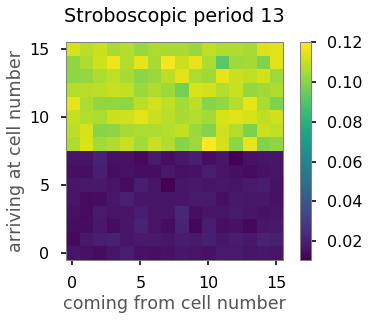

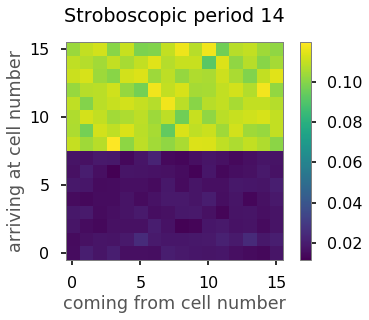

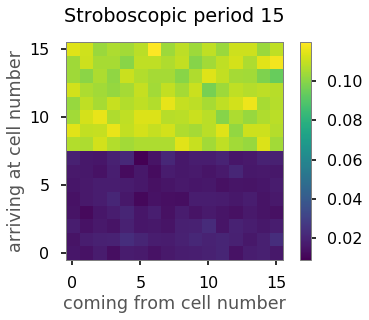

In [6]:
listOfMatrices=[]
for period in range(nPeriods*nStrobo):
    matrix = calcTransitionMatrix(resultsArray,nRadial, nAngular, nParticles, period)
    listOfMatrices.append(matrix)  

### TODO:


- check if transition matrix needs to be transposed or not
- change stroboscopic output: maybe half or quarter period?
- do production run for different k, nPeriods (maybe six different environments in total?)
- save transition matrix of chosen period to file

In [7]:
### which matrix to save? 